# Northwind database analysis

## Executive Summary 

In [1]:
#imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from math import sqrt
import scipy.stats as stats
from sklearn import preprocessing

from datetime import datetime


In [2]:
# create the SQL engine
# to use the large version of the databse:
# engine = create_engine('sqlite:///Northwind_large.sqlite', echo=True)

# to use the small version of the databse:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
con = engine.connect()
Session = sessionmaker(bind=engine)
session = Session()


2019-04-25 14:05:30,714 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-25 14:05:30,715 INFO sqlalchemy.engine.base.Engine ()
2019-04-25 14:05:30,717 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-25 14:05:30,719 INFO sqlalchemy.engine.base.Engine ()


In [3]:
# have a look at the tables
inspector = inspect(engine)
print(inspector.get_table_names())


2019-04-25 14:05:30,727 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-25 14:05:30,729 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [4]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

get_columns_info('OrderDetail')




2019-04-25 14:05:30,742 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-04-25 14:05:30,745 INFO sqlalchemy.engine.base.Engine ()
Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT


In [5]:
def make_column_list(table):
    cols = []  #make an empty list
    cols_dict = inspector.get_columns(table)  # make a dict of the column names from the SQL table
#     print(cols_list)
    for column in cols_dict:
        cols.append(column['name'])
#     print(cols)
    return cols


In [6]:
# small sample of order detail for testing
# rs = con.execute('SELECT * FROM OrderDetail LIMIT 25')

# get full orderdetail
rs = con.execute('SELECT * FROM OrderDetail')
order_detail = pd.DataFrame(rs.fetchall())

column_names = make_column_list('OrderDetail')
order_detail.columns = column_names

order_detail.head()

2019-04-25 14:05:30,764 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-04-25 14:05:30,767 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
column_names = make_column_list('Order')
column_names

2019-04-25 14:05:30,800 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-04-25 14:05:30,802 INFO sqlalchemy.engine.base.Engine ()


['Id',
 'CustomerId',
 'EmployeeId',
 'OrderDate',
 'RequiredDate',
 'ShippedDate',
 'ShipVia',
 'Freight',
 'ShipName',
 'ShipAddress',
 'ShipCity',
 'ShipRegion',
 'ShipPostalCode',
 'ShipCountry']

In [8]:
# customer table to pandas dataframe
rs = con.execute('SELECT * FROM Customer')
customers = pd.DataFrame(rs.fetchall())
column_names = make_column_list('Customer')
customers.columns = column_names

customers.head(10)


2019-04-25 14:05:30,814 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-04-25 14:05:30,816 INFO sqlalchemy.engine.base.Engine ()
2019-04-25 14:05:30,820 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-04-25 14:05:30,822 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745


In [9]:
# test orders table
# rs = con.execute('SELECT * FROM [Order]')
# orders = pd.DataFrame(rs.fetchall())
# orders.head()


# get full orders
rs = con.execute('SELECT * FROM [Order]')
orders = pd.DataFrame(rs.fetchall())

column_names = make_column_list('Order')
orders.columns = column_names



2019-04-25 14:05:30,848 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-04-25 14:05:30,850 INFO sqlalchemy.engine.base.Engine ()


In [10]:
# correct the incorect CustomerId values in orders_count
orders['CustomerId'].replace('ANTO', 'ANTON', inplace=True)
orders['CustomerId'].replace('DUMO', 'DUMON', inplace=True)
orders['CustomerId'].replace('OCEA', 'OCEAN', inplace=True)
orders['CustomerId'].replace('QUEE', 'QUEEN', inplace=True)
orders

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
5,10253,HANAR,3,2012-07-10,2012-07-24,2012-07-16,2,58.17,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
6,10254,CHOPS,5,2012-07-11,2012-08-08,2012-07-23,2,22.98,Chop-suey Chinese,Hauptstr. 31,Bern,Western Europe,3012,Switzerland
7,10255,RICSU,9,2012-07-12,2012-08-09,2012-07-15,3,148.33,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
8,10256,WELLI,3,2012-07-15,2012-08-12,2012-07-17,2,13.97,Wellington Importadora,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil
9,10257,HILAA,4,2012-07-16,2012-08-13,2012-07-22,3,81.91,HILARION-Abastos,Carrera 22 con Ave. Carlos Soublette #8-35,San Cristóbal,South America,5022,Venezuela


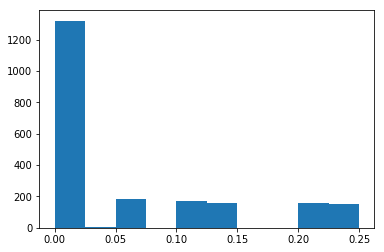

In [11]:
plt.hist(order_detail["Discount"])
plt.show()

In [12]:
# make a new column to calculate the line item total
order_detail['line_total'] = order_detail['Quantity'] * order_detail['UnitPrice'] * (1 - order_detail['Discount'])

order_detail.head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [13]:
order_detail.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,587.374960
std,241.378032,22.159019,29.827418,19.022047,0.083450,969.224235
min,10248.000000,1.000000,2.000000,1.000000,0.000000,4.800000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,147.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,337.750000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,656.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,15810.000000


Idea: Compare orders that contain at least one discounted item to orders that have no discounts.
* Is the average order total higher?
* Is the count of total items ordered higher?
* Is the count of unique products higher?

From prior labs:
q = """SELECT LastName, FirstName, COUNT(*) as TerritoriesAssigned from \
Employee \
JOIN EmployeeTerritory et on Employee.Id = et.employeeId \
GROUP BY Employee.lastname \
ORDER BY TerritoriesAssigned DESC"""

In [14]:
# rs = con.execute('SELECT * FROM [Order] JOIN OrderDetail on Order.OrderID = OrderDetail.OrderID WHERE OrderDetail.Discount > 0')
rs = con.execute('SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0')

orders_with_discount = pd.DataFrame(rs.fetchall())

orders_with_discount.columns = ['Id']

orders_with_discount.count()
orders_with_discount.head()


2019-04-25 14:05:31,345 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0
2019-04-25 14:05:31,347 INFO sqlalchemy.engine.base.Engine ()


,Id
0,10250
1,10251
2,10252
3,10254
4,10258


In [15]:
# make a list of orders that have no discounted items
orders_without_discount = orders.merge(orders_with_discount.drop_duplicates(), on=['Id'], how='left', indicator=True)

orders_without_discount = orders_without_discount[orders_without_discount._merge != 'both']

# orders_without_discount.head()

orders_without_discount.count()

# sources
# https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe
# https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/

Id                450
CustomerId        450
EmployeeId        450
OrderDate         450
RequiredDate      450
ShippedDate       440
ShipVia           450
Freight           450
ShipName          450
ShipAddress       450
ShipCity          450
ShipRegion        450
ShipPostalCode    446
ShipCountry       450
_merge            450
dtype: int64

In [16]:
orders.count()

Id                830
CustomerId        830
EmployeeId        830
OrderDate         830
RequiredDate      830
ShippedDate       809
ShipVia           830
Freight           830
ShipName          830
ShipAddress       830
ShipCity          830
ShipRegion        830
ShipPostalCode    811
ShipCountry       830
dtype: int64

In [17]:
orders_with_discount.count()

Id    380
dtype: int64

In [18]:
orders_without_discount.count()

Id                450
CustomerId        450
EmployeeId        450
OrderDate         450
RequiredDate      450
ShippedDate       440
ShipVia           450
Freight           450
ShipName          450
ShipAddress       450
ShipCity          450
ShipRegion        450
ShipPostalCode    446
ShipCountry       450
_merge            450
dtype: int64

830 orders:
* 450 orders have no discounts on any item
* 380 orders have at least one discounted product in the order.
* 19 orders have no value for ShipPostalCode.
* 21 orders have no value for ShippedDate.

In [19]:
rs = con.execute('SELECT * FROM OrderDetail JOIN [Order] on OrderDetail.Id = [Order].Id')
temp_df = pd.DataFrame(rs.fetchall())
temp_df.head(10)

2019-04-25 14:05:31,412 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail JOIN [Order] on OrderDetail.Id = [Order].Id
2019-04-25 14:05:31,414 INFO sqlalchemy.engine.base.Engine ()


""


Idea - Make a pandas dataframe of all orders where there is any item with a discount. 
Within those orders, what are the summary statistics for:
* The number of different SKU's in the order 
* Quantity of each SKU ordered. How does this compare to orders where the samei SKU has been ordered but there was no discount.
* 

And then compare those statistics to orders where there was no item with a discount.










add these columns to the order dataframe: 
* order_total
* unique_products_count
* all_items_total_qty_count

In [20]:
len(order_detail)

2155

In [21]:
order_detail.head()
print(order_detail.loc[order_detail['OrderId'] == 10248])
# print(df.loc[df['A'] == 'foo'])

         Id  OrderId  ProductId  UnitPrice  Quantity  Discount  line_total
0  10248/11    10248         11       14.0        12       0.0       168.0
1  10248/42    10248         42        9.8        10       0.0        98.0
2  10248/72    10248         72       34.8         5       0.0       174.0


In [22]:
# add blank columns to orders dataframe
orders['order_total'] = 0
orders['unique_products_count'] = 0
orders['all_items_total_qty_count'] = 0
orders['discount_flag'] = False #True if order contains any discounted items, otherwise False

orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,0,0,0,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,0,0,0,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,0,0,0,False
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,0,0,0,False
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,0,0,0,False


In [23]:
# get new column values, add to orders dataframe
for index, row in orders.iterrows():
    order_id = row['Id']     #row['Id'] gets the OrderId column value
    order_index =  orders.loc[orders['Id'] == order_id].index   #  order_index:  Int64Index([0], dtype='int64')
    
#     print ("order_id: ", order_id)
#     print ("order_index: ", order_index[0])  
    
# get the relevant rows from order_detail
    temp_df = order_detail.loc[order_detail['OrderId'] == order_id]
#     print(temp_df)
    
    order_total = 0
    order_product_ids_count = 0
    product_ids = []
    all_items_total_qty_count = 0
    discount_flag = False
    for index, row in temp_df.iterrows():
#         print(row)
        #for testing
#         print("UnitPrice: {}, Quantity: {}, Discount: {} ".format(row['UnitPrice'], row['Quantity'], row['Discount']))
        order_total += round((row['UnitPrice'] * row['Quantity']) * (1 - row['Discount']),2)
        #for testing
#     print("order_total: {}".format(order_total))
    
    #get the unique product id's
        product_ids.append(row['ProductId'])
        
    #count up the total # of units of all products in the order
        all_items_total_qty_count += row['Quantity']
        
    #check if any discount
        if discount_flag == False:
            if row['Discount'] > 0:
                discount_flag = True
    
    #make a set (only unique values)
    product_ids = set(product_ids)
    
# add these values to the order in the orders dataframe

#     print("Order {} complete. Order amount: {} - unique items: {} - item count: {}"
#           .format(order_id, order_total, len(product_ids), all_items_total_qty_count))
    
#     orders.iloc[order_index[0],'order_total'] = order_total
#     orders.ix[order_index[0], 'order_total'] = order_total  # .ix has been deprecated
    orders.iloc[order_index[0], orders.columns.get_loc('order_total')] = order_total
    orders.iloc[order_index[0], orders.columns.get_loc('unique_products_count')] = len(product_ids)
    orders.iloc[order_index[0], orders.columns.get_loc('all_items_total_qty_count')] = all_items_total_qty_count
    orders.iloc[order_index[0], orders.columns.get_loc('discount_flag')] = discount_flag
#     print(orders.iloc[order_index[0]])
#     print(orders.loc[orders['Id'] == order_id])
#               df.loc[df['column_name'] == some_value]
    

In [24]:
# make Id the index of orders dataframe
# orders.set_index('Id', inplace=True)

# look at orders
orders.head()



,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.00,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.40,2,49,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True


In [25]:

# discount_list = orders_with_discount['Id'].tolist()
# discount_list


In [26]:
# no_discount_list = orders_without_discount['Id'].tolist()
# no_discount_list


In [27]:
discount = orders[orders['discount_flag'] == True]
discount.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True
6,10254,CHOPS,5,2012-07-11,2012-08-08,2012-07-23,2,22.98,Chop-suey Chinese,Hauptstr. 31,Bern,Western Europe,3012,Switzerland,556.62,3,57,True
10,10258,ERNSH,1,2012-07-17,2012-08-14,2012-07-23,1,140.51,Ernst Handel,Kirchgasse 6,Graz,Western Europe,8010,Austria,1614.88,3,121,True


In [28]:
# no_discount = orders[orders['Id'].isin(no_discount_list)]
# no_discount.head()

no_discount = orders[orders['discount_flag'] == False]
no_discount.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.0,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.4,2,49,False
5,10253,HANAR,3,2012-07-10,2012-07-24,2012-07-16,2,58.17,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1444.8,3,102,False
7,10255,RICSU,9,2012-07-12,2012-08-09,2012-07-15,3,148.33,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland,2490.5,4,110,False
8,10256,WELLI,3,2012-07-15,2012-08-12,2012-07-17,2,13.97,Wellington Importadora,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil,517.8,2,27,False


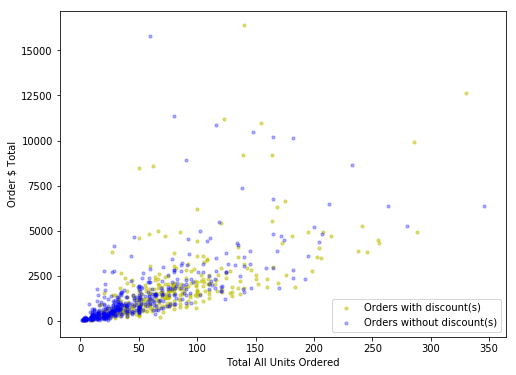

In [29]:
#original
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(discount['all_items_total_qty_count'], discount['order_total'], s=10, c='y', alpha=.5, label='Orders with discount(s)')
ax.scatter(no_discount['all_items_total_qty_count'], no_discount['order_total'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Total All Units Ordered")
ax.set_ylabel("Order $ Total")
plt.legend(loc='lower right')


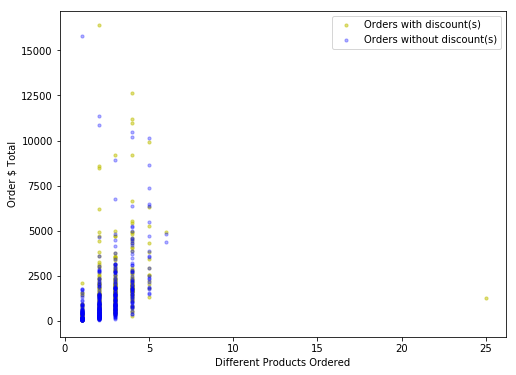

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(discount['unique_products_count'], discount['order_total'], s=10, c='y', alpha=.5, label='Orders with discount(s)')
ax.scatter(no_discount['unique_products_count'], no_discount['order_total'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Different Products Ordered")
ax.set_ylabel("Order $ Total")
plt.legend(loc='upper right')


#redu this plot to make a better visualization

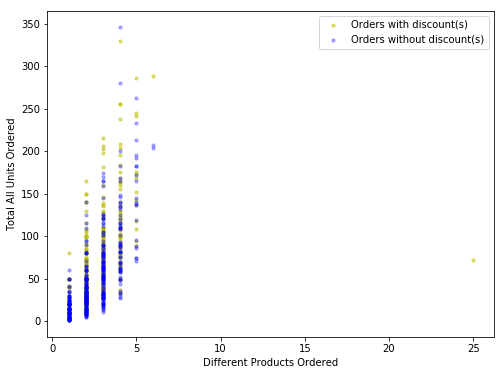

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(discount['unique_products_count'], discount['all_items_total_qty_count'], s=10, c='y', alpha=.5, label='Orders with discount(s)')
ax.scatter(no_discount['unique_products_count'], no_discount['all_items_total_qty_count'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Different Products Ordered")
ax.set_ylabel("Total All Units Ordered")
plt.legend(loc='upper right')


#redu this plot to make a better visualization

Next Steps:
* create totals for each customer:
    * total number of orders
    * total $ value of all orders
    * first order date
    * last order date
    * average orders/month (year?, etc.)
    






In [32]:
# add columns to customer dataframe: orders_count, orders_value, first_order_date, last_order_date
customers['orders_count'] = 0
customers['orders_value'] = 0
customers['first_order_date'] = 0
customers['last_order_date'] = 0

# cast date columns as pandas datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers.head()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,0,0,1970-01-01,1970-01-01
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,0,0,1970-01-01,1970-01-01
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,0,0,1970-01-01,1970-01-01
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,0,0,1970-01-01,1970-01-01
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,0,0,1970-01-01,1970-01-01


In [33]:
#get orders count
orders_count = orders.groupby("CustomerId")["Id"].nunique()
orders_count.head(10)

CustomerId
ALFKI     6
ANATR     4
ANTON     7
AROUT    13
BERGS    18
BLAUS     7
BLONP    11
BOLID     3
BONAP    17
BOTTM    14
Name: Id, dtype: int64

In [34]:
orders_count = orders_count.reset_index()
# orders_count.describe()
orders_count.head(10)

,CustomerId,Id
0,ALFKI,6
1,ANATR,4
2,ANTON,7
3,AROUT,13
4,BERGS,18
5,BLAUS,7
6,BLONP,11
7,BOLID,3
8,BONAP,17
9,BOTTM,14


In [35]:
# data.rename(columns={'gdp':'log(gdp)'}, inplace=True)
orders_count.rename(columns={'Id':'order_count'}, inplace=True)

In [36]:
orders_count.describe()

,order_count
count,89.000000
mean,9.325843
std,5.810991
min,1.000000
25%,5.000000
50%,8.000000
75%,12.000000
max,31.000000


In [37]:
# add order count to each customer record

for index, row in orders_count.iterrows():
#     print(row['CustomerId'])
#     print(row['order_count'])
#     break
    customer_id = row['CustomerId']
    order_count = row['order_count']
    customer_index = "NONE"
    
    # all customer id's in the customer table had five digits
    # this if/else statement was used to identify orders where the customer id was not five digits long
    if len(customer_id) == 5:                               
        customer_index = customers.loc[customers['Id'] == customer_id].index
        customers.iloc[customer_index, customers.columns.get_loc('orders_count')] = order_count
    else:
        print('CustomerId: {}'.format(customer_id))
        print('Order Count: {}'.format(order_count))
        print('Customer Index: {}'.format(customer_index))
        

    

In [38]:
#calculate customers total value of all orders
orders_total = orders.groupby("CustomerId")['order_total'].agg(sum)

orders_total = orders_total.reset_index()
orders_total.head()

,CustomerId,order_total
0,ALFKI,4273.00
1,ANATR,1402.95
2,ANTON,7023.98
3,AROUT,13390.65
4,BERGS,24927.58


In [39]:
# add the total value of all orders to each customer
for index, row in orders_total.iterrows():
    customer_id = row['CustomerId']
    order_total = row['order_total']
    customer_index = customers.loc[customers['Id'] == customer_id].index
    customers.iloc[customer_index,customers.columns.get_loc('orders_value')] = order_total

In [40]:
customers.head(10)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,1970-01-01,1970-01-01
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,1970-01-01,1970-01-01
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,1970-01-01,1970-01-01
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,1970-01-01,1970-01-01
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,1970-01-01,1970-01-01
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924,7,3239.80,1970-01-01,1970-01-01
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32,11,18534.08,1970-01-01,1970-01-01
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99,3,4232.85,1970-01-01,1970-01-01
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41,17,21963.24,1970-01-01,1970-01-01
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745,14,20801.59,1970-01-01,1970-01-01


In [41]:
customers.describe()

,orders_count,orders_value
count,91.000000,91.000000
mean,9.120879,13909.813297
std,5.908253,20103.531743
min,0.000000,0.000000
25%,5.000000,3166.755000
50%,8.000000,7023.980000
75%,12.000000,16646.830000
max,31.000000,110277.320000


In [42]:
# inspect the count of orders for customers

order_counts = customers.groupby('orders_count')['orders_count'].count()
order_counts
# order_counts = order_counts.reset_index()

orders_count
0      2
1      1
2      2
3      7
4      6
5     10
6      8
7      7
8      4
9      5
10    11
11     4
12     3
13     3
14     6
15     3
17     1
18     3
19     2
28     1
30     1
31     1
Name: orders_count, dtype: int64

Two customers have no order, one customer has only one order.

In [43]:
under_two_orders = customers.loc[customers['orders_count'] < 2]
print (under_two_orders)

       Id                           CompanyName      ContactName  \
12  CENTC            Centro comercial Moctezuma  Francisco Chang   
21  FISSA  FISSA Fabrica Inter. Salchichas S.A.       Diego Roel   
56  PARIS                     Paris spécialités   Marie Bertrand   

          ContactTitle                  Address         City           Region  \
12   Marketing Manager  Sierras de Granada 9993  México D.F.  Central America   
21  Accounting Manager       C/ Moralzarzal, 86       Madrid  Southern Europe   
56               Owner  265, boulevard Charonne        Paris   Western Europe   

   PostalCode Country            Phone              Fax  orders_count  \
12      05022  Mexico     (5) 555-3392     (5) 555-7293             1   
21      28034   Spain   (91) 555 94 44   (91) 555 55 93             0   
56      75012  France  (1) 42.34.22.66  (1) 42.34.22.77             0   

    orders_value first_order_date last_order_date  
12         100.8       1970-01-01      1970-01-01  
21   

In [44]:
one_order = orders.loc[orders['CustomerId'] == 'CENTC']
one_order

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
11,10259,CENTC,4,2012-07-18,2012-08-15,2012-07-25,3,3.25,Centro comercial Moctezuma,Sierras de Granada 9993,México D.F.,Central America,05022,Mexico,100.8,2,11,False


In [45]:
one_order_customer = customers.loc[customers['Id'] == "CENTC"]
one_order_customer

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
12,CENTC,Centro comercial Moctezuma,Francisco Chang,Marketing Manager,Sierras de Granada 9993,México D.F.,Central America,05022,Mexico,(5) 555-3392,(5) 555-7293,1,100.8,1970-01-01,1970-01-01


In [46]:
no_order = orders.loc[orders['CustomerId'] == 'FISSA']
no_order

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag


In [47]:
no_order = orders.loc[orders['CustomerId'] == 'PARIS']
no_order

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag


In [48]:
# no_order_customer = customers.loc[customers['order_total'] == 0]  #ask why this doesn't work
no_order_customer = customers.loc[customers['Id'] == 'FISSA']

no_order_customer

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
21,FISSA,FISSA Fabrica Inter. Salchichas S.A.,Diego Roel,Accounting Manager,"C/ Moralzarzal, 86",Madrid,Southern Europe,28034,Spain,(91) 555 94 44,(91) 555 55 93,0,0.0,1970-01-01,1970-01-01


In [49]:
no_order_customer = customers.loc[customers['Id'] == 'PARIS']

no_order_customer

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
56,PARIS,Paris spécialités,Marie Bertrand,Owner,"265, boulevard Charonne",Paris,Western Europe,75012,France,(1) 42.34.22.66,(1) 42.34.22.77,0,0.0,1970-01-01,1970-01-01


In [50]:
#get first and last order dates
# order_dates = orders.groupby("CustomerId")['OrderDate']

for index, row in customers.iterrows():
    #iterrate through customers list
    #set first and last order date variables, cast as time_date
    first_order_date = np.NaN
    last_order_date = np.NaN
    first_order_date = pd.to_datetime(first_order_date)
    last_order_date = pd.to_datetime(last_order_date)

    # get current customer id
    customer_id = row['Id']
    temp_list = []
    # iterrate through orders
    for index, row in orders.iterrows():
        if row['CustomerId'] == customer_id:
            temp_list.append(row['OrderDate'])
#     print(temp_list)
    temp_list.sort()
    customer_index = customers.loc[customers['Id'] == customer_id].index
    
    if len(temp_list) == 0: #flag to see if any customers have no orders
        print('No order found for customer: {}'.format(customer_id))
        
    if len(temp_list) == 1: #handle the case where there is only one order
        print('Customer: {} has only one order.'.format(customer_id))
        temp_date = temp_list.pop(0)
        customers.iloc[customer_index, customers.columns.get_loc('first_order_date')] = temp_date
        customers.iloc[customer_index, customers.columns.get_loc('last_order_date')] = temp_date
        
    if temp_list: # case there there is more than one order
        customers.iloc[customer_index, customers.columns.get_loc('first_order_date')] = temp_list.pop(0)
        customers.iloc[customer_index, customers.columns.get_loc('last_order_date')] = temp_list.pop(-1)
    

Customer: CENTC has only one order.
No order found for customer: FISSA
No order found for customer: PARIS


In [51]:
customers.describe()

,orders_count,orders_value
count,91.000000,91.000000
mean,9.120879,13909.813297
std,5.908253,20103.531743
min,0.000000,0.000000
25%,5.000000,3166.755000
50%,8.000000,7023.980000
75%,12.000000,16646.830000
max,31.000000,110277.320000


In [52]:
# create some columns: average value of each customers orders, age of customer
# cast date columns as datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers['order_avg'] = customers['orders_value'] / customers['orders_count']
today = pd.to_datetime('today')
customers['scaled_customer_age'] = (today - customers['first_order_date']).dt.days

customers.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,2013-08-25,2014-04-09,712.166667,2069
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,2012-09-18,2014-03-04,350.737500,2410
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,2012-11-27,2014-01-28,1003.425714,2340
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,2012-11-15,2014-04-10,1030.050000,2352
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,2012-08-12,2014-03-04,1384.865556,2447


In [53]:
# normalize customer_age
x = customers[['scaled_customer_age']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

customers['scaled_customer_age'] = x_scaled


# https://chrisalbon.com/python/data_wrangling/pandas_normalize_column/

In [54]:
# customers.drop('customer_age', axis=1, inplace=True)

In [55]:
customers.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,2013-08-25,2014-04-09,712.166667,0.009752
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,2012-09-18,2014-03-04,350.737500,0.030934
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,2012-11-27,2014-01-28,1003.425714,0.026586
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,2012-11-15,2014-04-10,1030.050000,0.027331
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,2012-08-12,2014-03-04,1384.865556,0.033232


In [56]:
# temp = customers.sort_values(by=['order_avg'])  # not working as intended
# temp.describe()

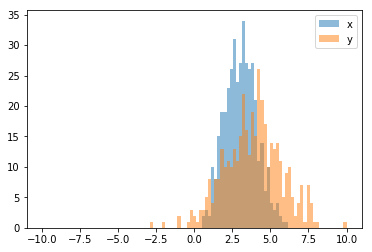

In [57]:
# sample histogram
import random
import numpy
from matplotlib import pyplot

x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = numpy.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

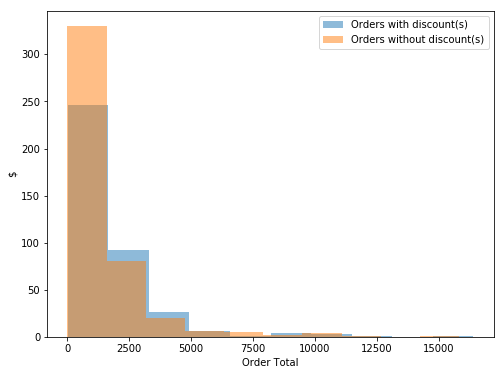

In [58]:
#graph of average order amount, discounted vs. not discounted

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(discount['order_total'], alpha=.5, label='Orders with discount(s)')
ax.hist(no_discount['order_total'], alpha=.5, label='Orders without discount(s)')
ax.set_xlabel("Order Total")
ax.set_ylabel("$")
plt.legend(loc='upper right')

/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


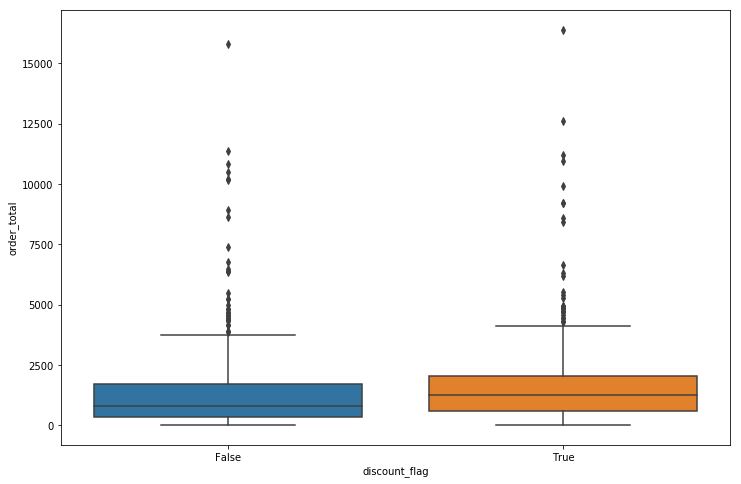

In [59]:
#try box plots
data = pd.concat([orders['order_total'], orders['discount_flag']], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
# fig = sns.boxplot(x='discount_flag', y='order_total', data=data, orient='h')  #???
fig = sns.boxplot(x='discount_flag', y='order_total', data=data)
plt.show()


In [60]:
# discount.head()
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.00,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.40,2,49,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True


As we said previously, scientific experiments actually have 2 hypotheses:


Null Hypothesis: There is no relationship between A and B Example: "There is no relationship between this flu medication and a reduced recovery time from the flu".

The Null Hypothesis is usually denoted as  HOHO 
Alternative Hypothesis: The hypothesis we traditionally think of when thikning of a hypothesis for an experiment Example: "This flu medication reduces recovery time for the flu."

The Alternative Hypothesis is usually denoted as  HaHa 
P-Values and Alpha Values
No matter what you're experimenting on, good experiments come down down to one question: Is our p-value less than our alpha value? Let's dive into what each of these values represents, and why they're so important to experimental design.

P-value: The calculated probability of arriving at this data randomly.

If we calculate a p-value and it comes out to 0.03, we can interpret this as saying "There is a 3% chance that the results I'm seeing are actually due to randomness or pure luck".

αα  (alpha value): The marginal threshold at which we're okay with with rejecting the null hypothesis.

An alpha value can be any value we set between 0 and 1. However, the most common alpha value in science is 0.05 (although this is somewhat of a controversial topic in the scientific community, currently).

If we set an alpha value of  α=0.05α=0.05 , we're essentially saying "I'm okay with accepting my alternative hypothesis as true if there is less than a 5% chance that the results that I'm seeing are actually due to randomness".





In [61]:
# run a hypothesis test comparing orders with discount to those without
# select multiple samples of the orders and look at the distribution of the sample means

no_discount['order_total'].describe()

count      450.000000
mean      1375.331844
std       1792.781223
min         12.500000
25%        360.250000
50%        810.250000
75%       1731.670000
max      15810.000000
Name: order_total, dtype: float64

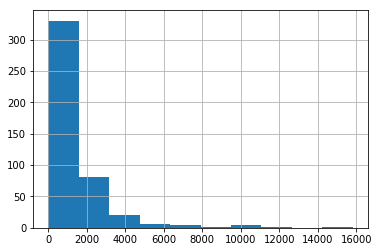

In [62]:
no_discount['order_total'].hist()

In [63]:
''' Random sampling - Random n rows '''
# no_discount_sample = no_discount['order_total'].sample(n=30)
# # print(no_discount_sample)
# no_discount_sample.describe()

# http://www.datasciencemadesimple.com/random-sampling-pandas-python-2/

' Random sampling - Random n rows '

In [64]:
discount['order_total'].describe()

count      380.000000
mean      1702.351789
std       1892.448250
min         23.800000
25%        587.750000
50%       1244.880000
75%       2027.910000
max      16387.500000
Name: order_total, dtype: float64

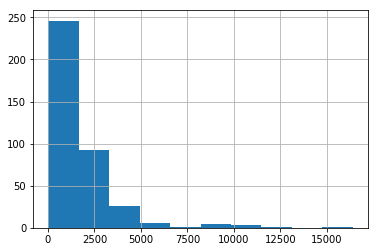

In [65]:
discount['order_total'].hist()

In [66]:
# discount_sample = discount['order_total'].sample(n=30)
# discount_sample.describe()

In [67]:
# create fields for total # of orders, # of orders with a discount, percentage of orders with a discount
# run a hypohtesis test comparing customers with discount vs. no discount, for average value of that customers orders

# calculate the mean and standard deviation for orders with no discount and orders with a discount
# 


# Ho = There is no difference between average order total of orders with any discount(s) and orders with at 
#  least one item discounte.
# Ha = Orders with at least one discounted item have a higher average order total than orders without any discouts.

# alpha = 0.05 . This is the threshold for the p-value that I will use to accept the Ha. If there is a 
# 5% or less probability of obtaining the order total average from the orders with a discount. 
# If the average order total
# for the orders with a total is only 5% likely to be obtained from the samples of the orders with a discount I 
# will 


# mu_2 = the mean order value for orders with a discounted item
# mu_2 = discount.mean()




In [68]:
# funciton to create a ramdom sample of size n from a list

def create_samples(list_of_values, n):
    full_list = []
    while len(full_list) < n:
        random_sample = np.random.choice(list_of_values)
        full_list.append(random_sample)
    return full_list

def create_distribution_of_sample_means(list_of_values, distribution_size, n):
    sample_means = []
    while len(sample_means) < distribution_size:
        sample = create_samples(list_of_values, n)
        sample_mean = np.mean(sample)
        sample_means.append(sample_mean)
#         print("Sample mean # {} done.".format(len(sample_means)))
    return sample_means


In [69]:
# create the list of sample means from both groups
discount_sample_means = create_distribution_of_sample_means(discount['order_total'], 100, 30)
no_discount_sample_means = create_distribution_of_sample_means(no_discount['order_total'], 100, 30)

# calculate the control mean & standard deviation
mu = np.mean(no_discount_sample_means)
sigma = np.std(no_discount_sample_means)

# calculate the treatment mean and number of samples
x_bar = np.mean(discount_sample_means)
n = len(discount_sample_means)

# calculate z-score
z = (x_bar - mu) / (sigma/sqrt(n))

# calcule P-value
p = 1 - stats.norm.cdf(z)


In [70]:
print('Z-score: {:.4f}'.format(z))
print("P-value: {:.12f}".format(p))


Z-score: 9.4289
P-value: 0.000000000000


In [71]:
# use stats built-in t-test
stats.ttest_ind(no_discount_sample_means, discount_sample_means, equal_var=False)


Ttest_indResult(statistic=-6.257735469012463, pvalue=2.416070732373714e-09)

The very small P-value indicates that it is extremely unlikely that the mean order total from the discounted orders would be randomly obtained from the non-discounted orders. The null hypothesis can be rejected.


In [72]:
# need to calculate cohens d - (effect size), confidence interval, etc. ???


In [73]:
# check how "normal" the distribution of the set of samples is for both groups
print("Normality test of Samples from Non-Discounted Orders:")
print(stats.normaltest(no_discount_sample_means))
print("----")
print("Normality test of Samples from Discounted Orders:")
print(stats.normaltest(discount_sample_means))

Normality test of Samples from Non-Discounted Orders:
NormaltestResult(statistic=38.18680851262508, pvalue=5.10316829232605e-09)
----
Normality test of Samples from Discounted Orders:
NormaltestResult(statistic=7.3945856000417685, pvalue=0.024790548681013807)


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


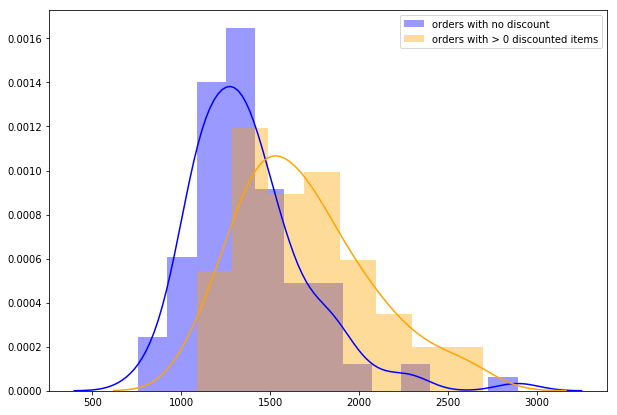

In [74]:
plt.figure(figsize=(10,7))

sns.distplot(no_discount_sample_means, color="blue", label="orders with no discount")
sns.distplot(discount_sample_means, color="orange", label='orders with > 0 discounted items')
plt.legend()


In [75]:
# trying to understand kurtosis test
uniform = list(range(100))
stats.kurtosistest(uniform)


KurtosistestResult(statistic=-5.799128107807834, pvalue=6.666059473262186e-09)

In [76]:
# normal test on the uniform dist
stats.normaltest(uniform)

NormaltestResult(statistic=34.673555743797884, pvalue=2.9561947150806057e-08)

(array([  2.,   5.,  30., 107., 207., 243., 226., 123.,  43.,  14.]),
 array([-3.84323982, -3.15822949, -2.47321916, -1.78820883, -1.1031985 ,
        -0.41818816,  0.26682217,  0.9518325 ,  1.63684283,  2.32185316,
         3.00686349]),
 <a list of 10 Patch objects>)

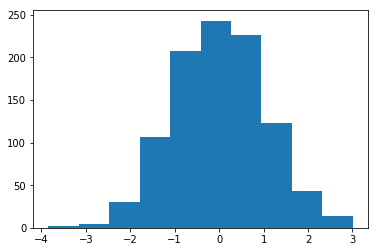

In [77]:
s = np.random.normal(0, 1, 1000)
plt.hist(s)

In [78]:
b

KurtosistestResult(statistic=-0.22463385681160752, pvalue=0.8222641239983383)

In [79]:
stats.normaltest(s)

NormaltestResult(statistic=0.4581023567474949, pvalue=0.795287830925709)

In [80]:
# My analyis above can be for a second question: "Do discounts result in bigger # value orders?"
# I didn't really answer the first question
# Do discounts have a statistically significant effect on the number of products customers order?
# If so, at what level(s) of discount?

# Additinal questions:
# Is the age of customers related to how many different products they have ordered?
# Is the age of customers related to how large their orders are. ie., does average order size increase over time?


In [81]:
# answering question #1:
# pull 

In [82]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [226]:
# create a dataframe to look at the average quantity of each product ordered by the discount
mean_quantity_per_discount = pd.DataFrame(order_detail.groupby(['ProductId','Discount'])['Quantity'].mean())
mean_quantity_per_discount.reset_index(inplace=True)
mean_quantity_per_discount

,ProductId,Discount,Quantity
0,1,0.00,17.772727
1,1,0.05,20.000000
2,1,0.10,10.000000
3,1,0.15,19.600000
4,1,0.20,42.500000
5,1,0.25,27.800000
6,2,0.00,21.473684
7,2,0.05,16.666667
8,2,0.10,20.000000
9,2,0.15,25.000000


ProductId: 1
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [17.77, 20.0, 10.0, 19.6, 42.5, 27.8]


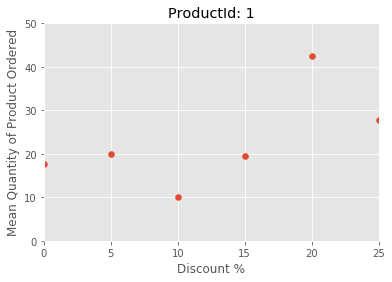

ProductId: 2
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [21.47, 16.67, 20.0, 25.0, 24.7, 34.5]


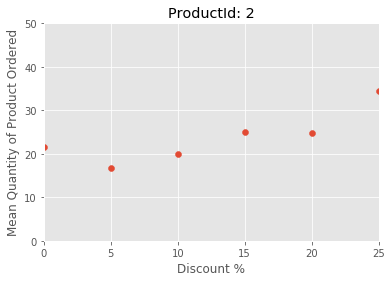

ProductId: 3
Discount Levels: [0.0, 10.0]
Mean Quantity: [28.8, 20.0]


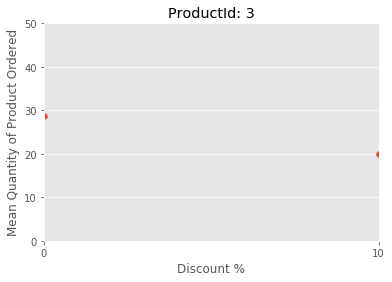

ProductId: 4
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [17.2, 50.0, 22.5, 50.0, 18.0, 27.5]


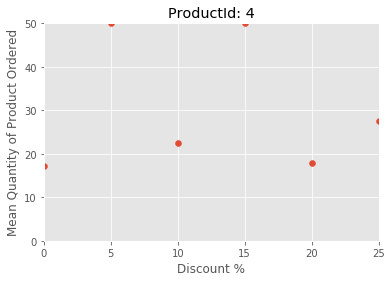

ProductId: 5
Discount Levels: [0.0, 10.0, 20.0, 25.0]
Mean Quantity: [29.33, 15.0, 38.5, 30.0]


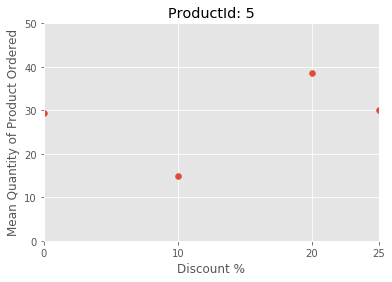

ProductId: 6
Discount Levels: [0.0, 2.0, 5.0, 25.0]
Mean Quantity: [26.75, 1.0, 33.0, 20.0]


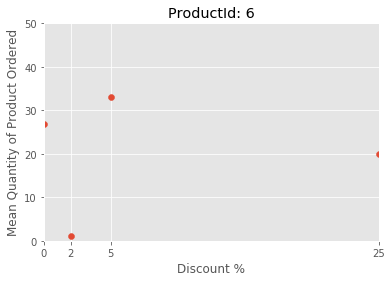

ProductId: 7
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0]
Mean Quantity: [29.9, 13.0, 20.0, 26.5, 10.0]


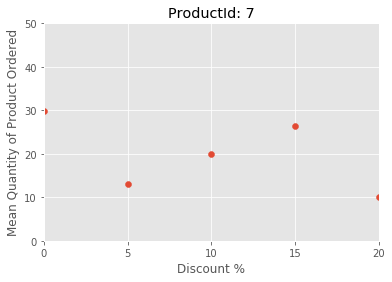

ProductId: 8
Discount Levels: [0.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [30.0, 2.0, 15.0, 30.0, 70.0]


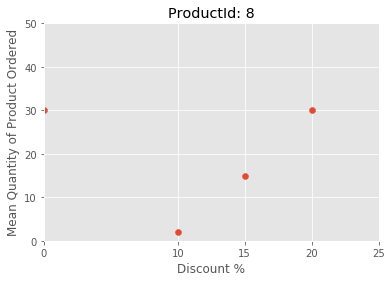

ProductId: 9
Discount Levels: [0.0, 10.0, 15.0, 25.0]
Mean Quantity: [4.5, 20.0, 16.0, 50.0]


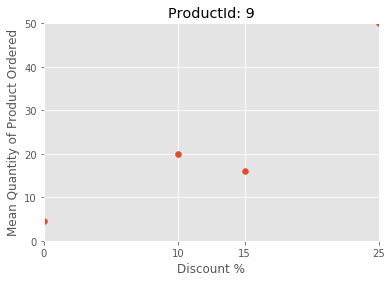

ProductId: 10
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [19.45, 20.0, 19.0, 49.33, 25.0, 18.0]


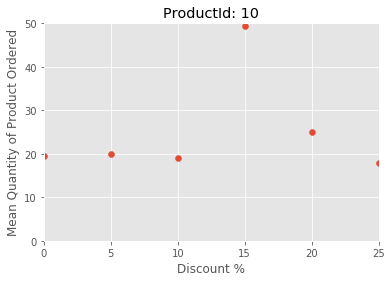

ProductId: 11
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [15.12, 15.0, 40.0, 35.0, 22.67, 18.75]


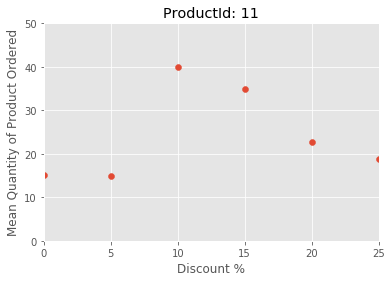

ProductId: 12
Discount Levels: [0.0, 5.0, 15.0, 20.0, 25.0]
Mean Quantity: [32.14, 11.33, 33.0, 4.0, 15.0]


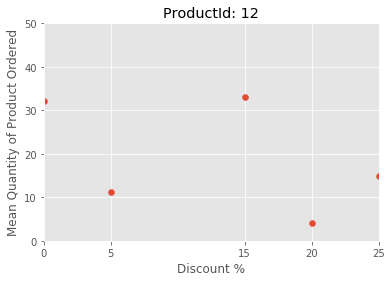

ProductId: 13
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [20.59, 19.0, 12.5, 44.8, 3.0, 20.0]


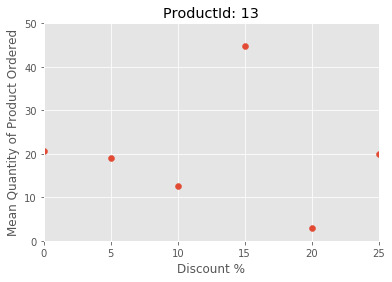

ProductId: 14
Discount Levels: [0.0, 3.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [20.17, 1.0, 15.0, 11.5, 8.0, 22.5, 31.0]


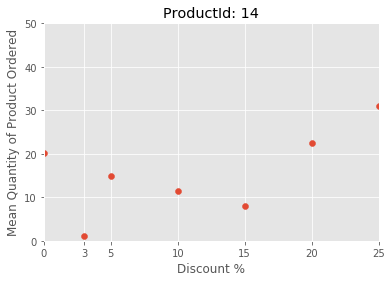

ProductId: 15
Discount Levels: [0.0, 5.0]
Mean Quantity: [21.25, 18.5]


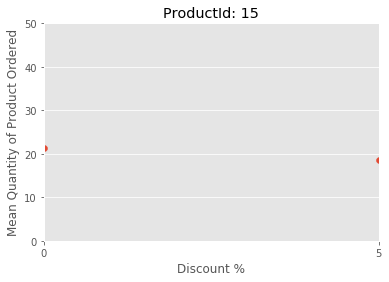

ProductId: 16
Discount Levels: [0.0, 3.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [23.35, 2.0, 26.17, 27.0, 33.0, 20.0, 46.67]


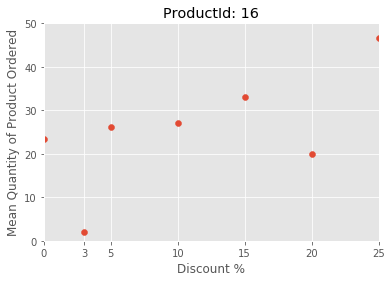

ProductId: 17
Discount Levels: [0.0, 5.0, 10.0, 20.0, 25.0]
Mean Quantity: [21.9, 26.0, 36.5, 37.5, 33.4]


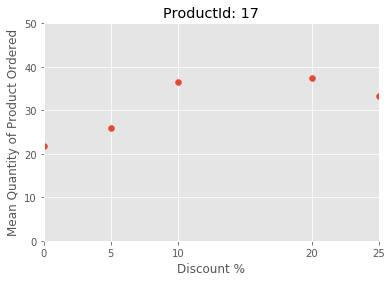

ProductId: 18
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [18.71, 20.0, 15.5, 18.0, 34.0, 13.67]


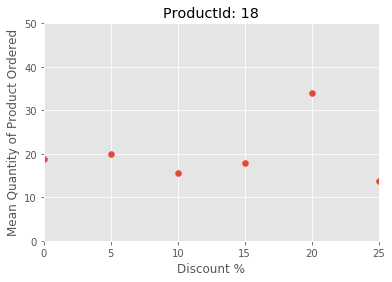

ProductId: 19
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [19.05, 30.4, 19.0, 4.0, 20.67, 9.67]


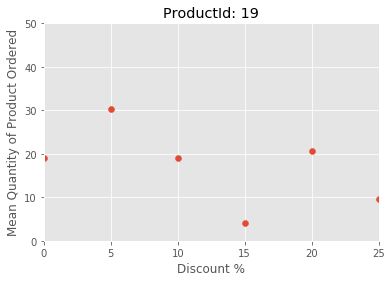

ProductId: 20
Discount Levels: [0.0, 4.0, 5.0, 10.0, 20.0, 25.0]
Mean Quantity: [17.11, 1.0, 36.67, 15.0, 21.0, 12.0]


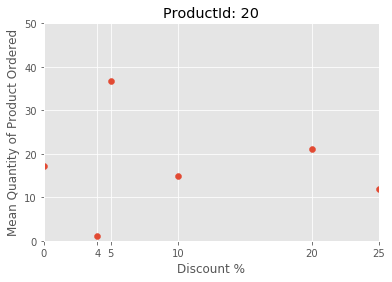

ProductId: 21
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [26.36, 37.33, 14.71, 30.0, 35.0, 30.5]


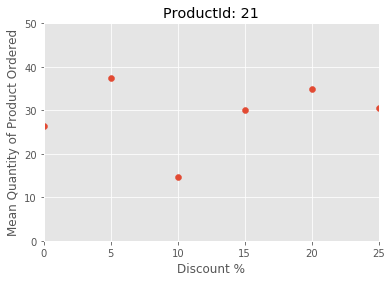

ProductId: 22
Discount Levels: [0.0, 5.0, 25.0]
Mean Quantity: [26.83, 6.0, 20.0]


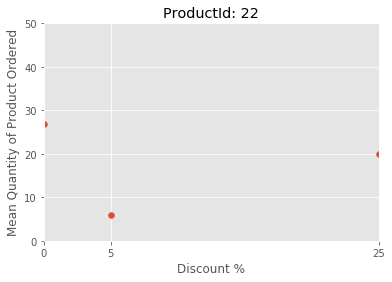

ProductId: 23
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [25.47, 20.0, 70.0, 70.0, 30.0, 8.0]


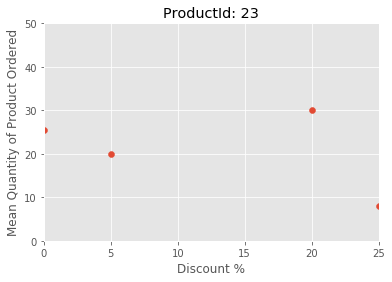

ProductId: 24
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [21.33, 34.0, 26.67, 15.0, 21.0, 23.2]


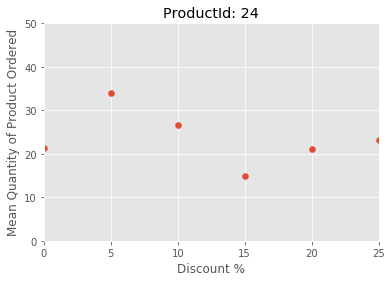

ProductId: 25
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [15.62, 28.33, 18.0, 20.0, 8.0, 18.0]


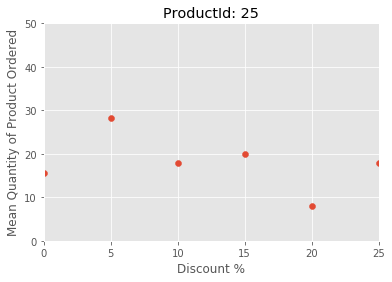

ProductId: 26
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [19.38, 17.5, 12.0, 34.6, 21.0, 52.5]


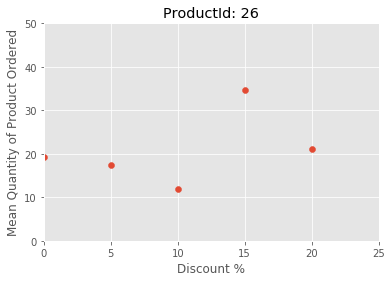

ProductId: 27
Discount Levels: [0.0, 25.0]
Mean Quantity: [43.75, 15.0]


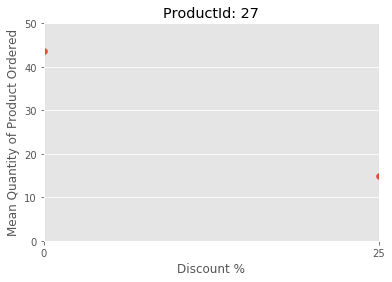

ProductId: 28
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [16.04, 39.0, 36.25, 14.0, 5.0, 15.0]


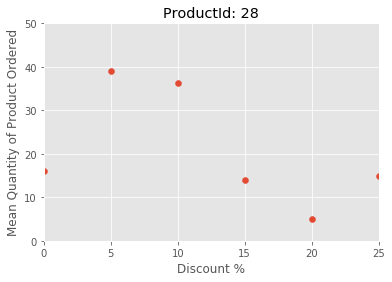

ProductId: 29
Discount Levels: [0.0, 5.0, 10.0, 15.0, 25.0]
Mean Quantity: [22.26, 13.5, 21.5, 24.0, 33.67]


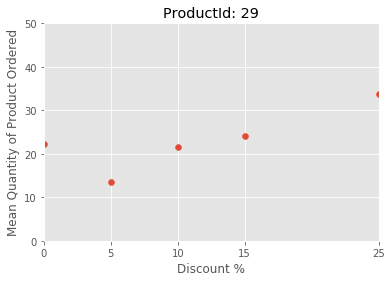

ProductId: 30
Discount Levels: [0.0, 5.0, 10.0, 20.0, 25.0]
Mean Quantity: [17.72, 14.33, 18.0, 23.33, 23.14]


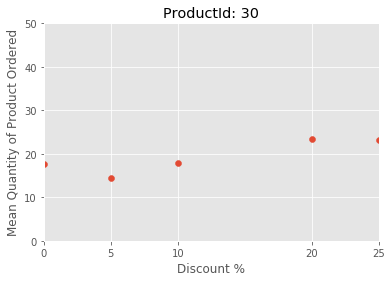

ProductId: 31
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [23.28, 29.2, 19.2, 38.33, 49.2, 22.0]


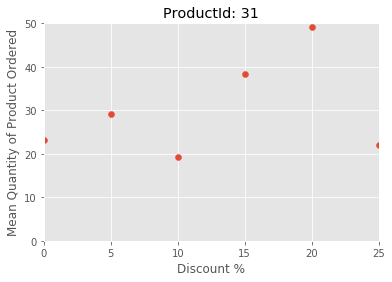

ProductId: 32
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0]
Mean Quantity: [15.86, 15.0, 28.33, 24.0, 20.67]


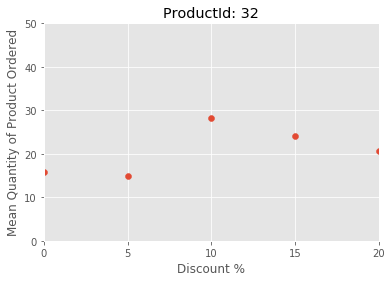

ProductId: 33
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [24.71, 30.0, 20.0, 9.33, 14.0, 40.0]


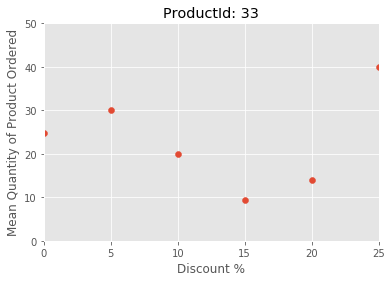

ProductId: 34
Discount Levels: [0.0, 5.0, 15.0, 20.0, 25.0]
Mean Quantity: [22.42, 45.0, 60.0, 16.0, 10.0]


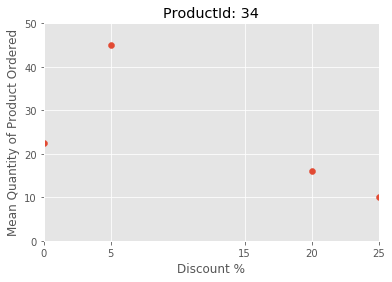

ProductId: 35
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [21.24, 18.0, 31.67, 35.0, 47.5, 19.5]


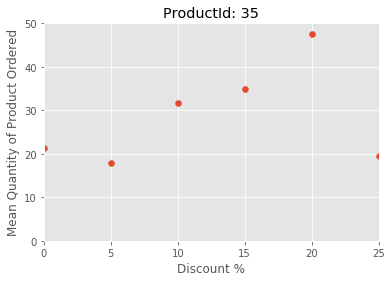

ProductId: 36
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [27.44, 20.0, 17.5, 25.0, 24.0, 27.0]


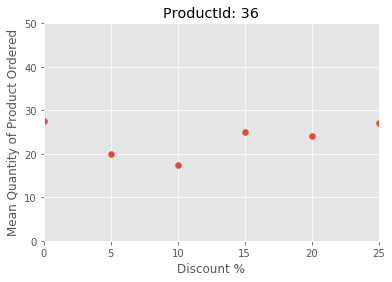

ProductId: 37
Discount Levels: [0.0, 10.0, 20.0]
Mean Quantity: [11.75, 18.0, 60.0]


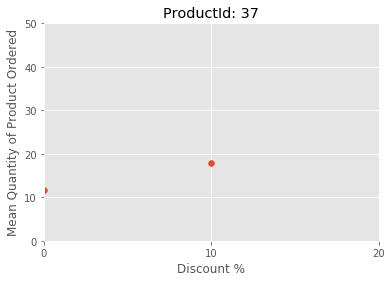

ProductId: 38
Discount Levels: [0.0, 5.0, 10.0, 20.0, 25.0]
Mean Quantity: [22.86, 29.0, 9.5, 49.5, 40.0]


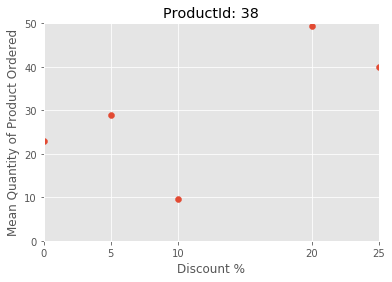

ProductId: 39
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [21.44, 41.0, 58.5, 20.0, 6.5, 20.5]


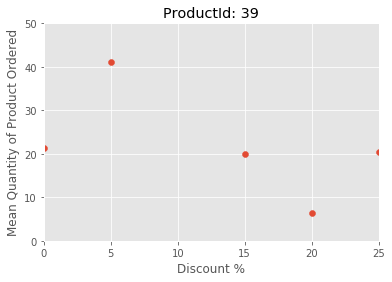

ProductId: 40
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [22.88, 46.0, 21.4, 60.0, 26.0, 50.0]


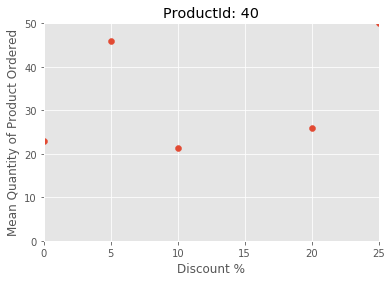

ProductId: 41
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [19.97, 15.57, 30.4, 25.0, 22.5, 25.5]


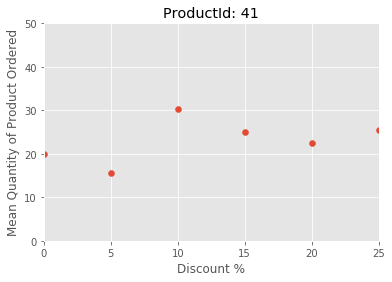

ProductId: 42
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [17.83, 25.5, 42.0, 26.0, 35.0, 40.0]


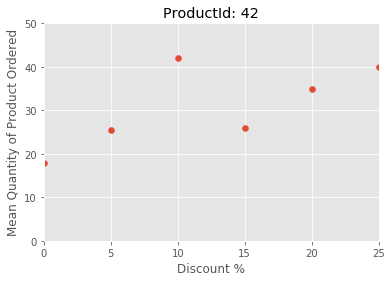

ProductId: 43
Discount Levels: [0.0, 5.0, 15.0, 20.0, 25.0]
Mean Quantity: [18.75, 40.0, 23.67, 20.0, 27.0]


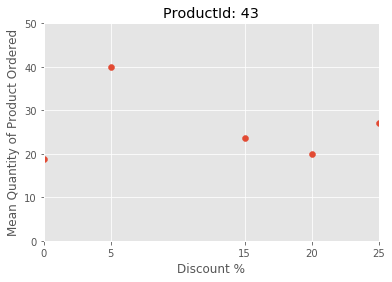

ProductId: 44
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [17.31, 75.67, 26.0, 7.67, 28.0, 18.0]


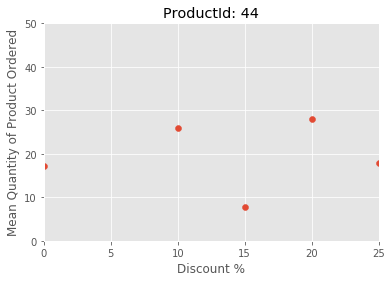

ProductId: 45
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0]
Mean Quantity: [31.43, 27.0, 30.0, 70.0, 30.33]


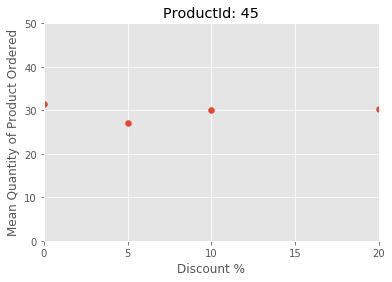

ProductId: 46
Discount Levels: [0.0, 2.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [24.0, 3.0, 24.0, 24.5, 18.0, 10.0, 8.0]


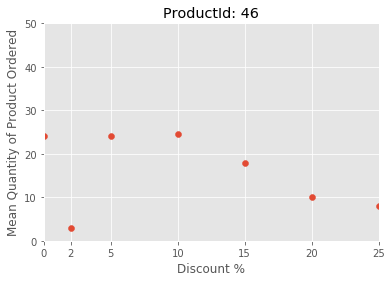

ProductId: 47
Discount Levels: [0.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [22.0, 13.5, 6.0, 16.0, 37.5]


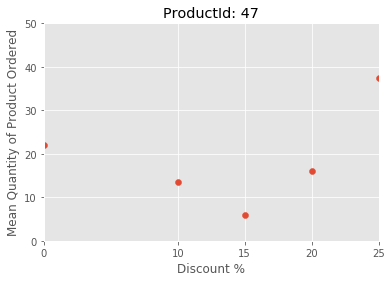

ProductId: 48
Discount Levels: [0.0, 10.0, 15.0]
Mean Quantity: [24.0, 10.5, 31.0]


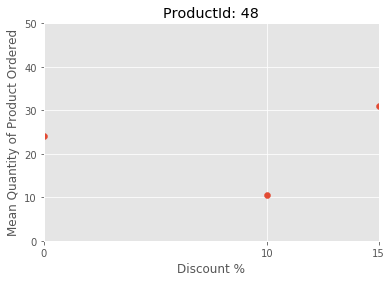

ProductId: 49
Discount Levels: [0.0, 5.0, 10.0, 15.0]
Mean Quantity: [25.2, 27.5, 42.0, 15.0]


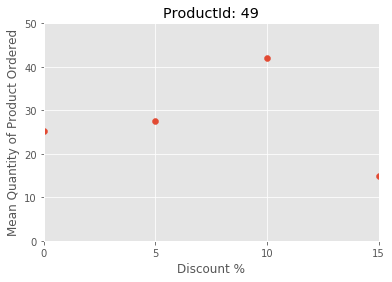

ProductId: 50
Discount Levels: [0.0, 5.0, 10.0]
Mean Quantity: [25.0, 25.0, 17.5]


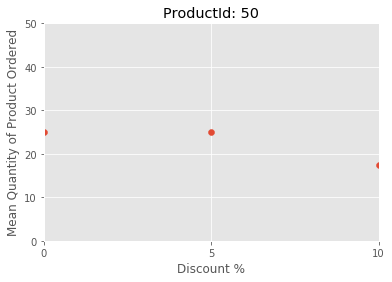

ProductId: 51
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [17.68, 46.25, 6.0, 33.67, 34.0, 26.0]


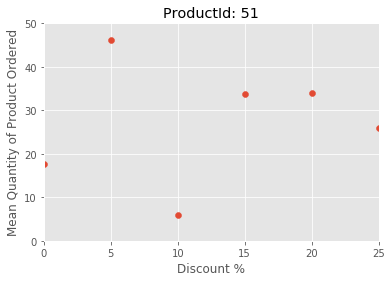

ProductId: 52
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [17.7, 11.67, 15.0, 8.0, 30.0, 20.0]


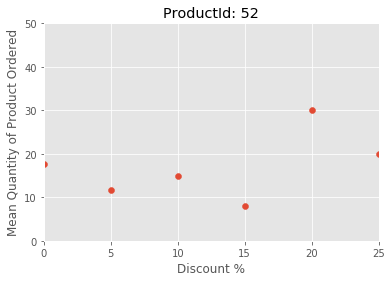

ProductId: 53
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0]
Mean Quantity: [21.95, 14.0, 38.8, 15.0, 23.0]


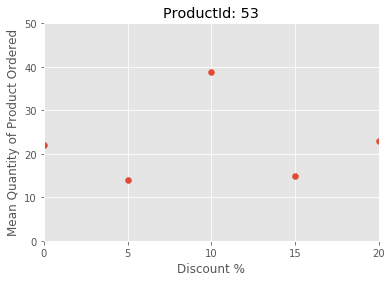

ProductId: 54
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [21.52, 24.0, 7.67, 37.33, 6.25, 29.75]


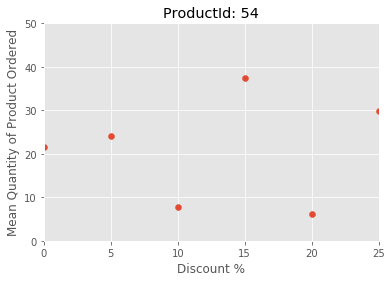

ProductId: 55
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [16.21, 13.4, 55.6, 38.67, 28.33, 43.33]


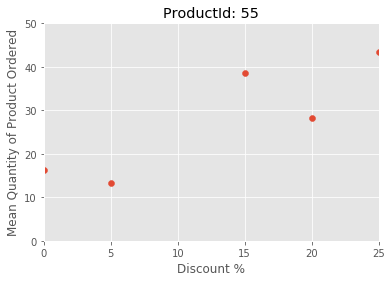

ProductId: 56
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [25.7, 32.6, 40.0, 18.8, 21.8, 21.5]


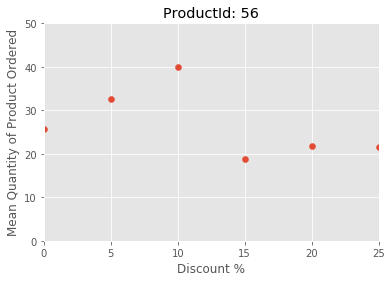

ProductId: 57
Discount Levels: [0.0, 5.0, 10.0, 20.0, 25.0]
Mean Quantity: [20.83, 12.5, 5.0, 15.0, 14.0]


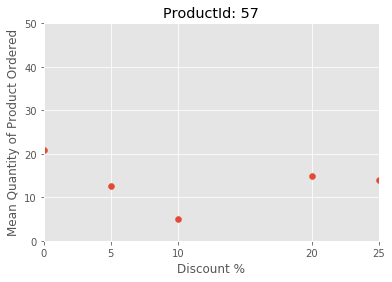

ProductId: 58
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [18.71, 40.0, 40.0, 12.0, 47.25, 21.0]


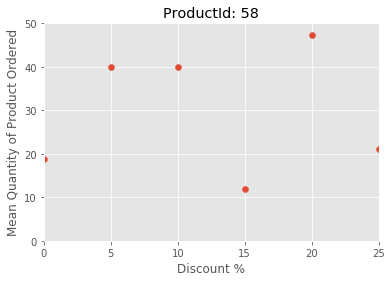

ProductId: 59
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [24.26, 21.57, 27.5, 36.0, 39.67, 65.0]


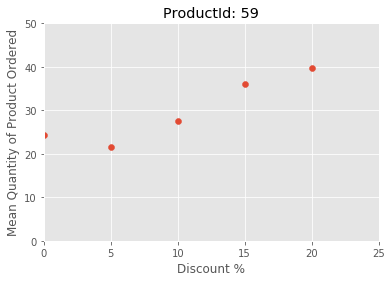

ProductId: 60
Discount Levels: [0.0, 5.0, 6.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [27.32, 51.83, 2.0, 27.0, 29.2, 24.33, 39.8]


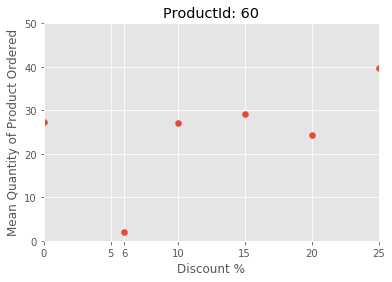

ProductId: 61
Discount Levels: [0.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [13.71, 15.0, 62.0, 18.75, 120.0]


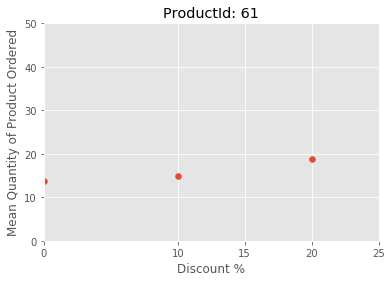

ProductId: 62
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [23.06, 20.0, 22.25, 30.75, 10.0, 17.2]


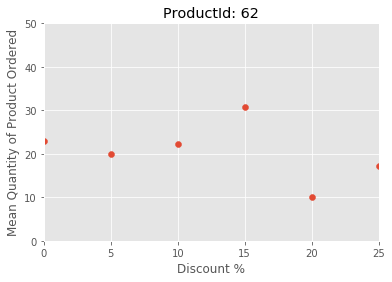

ProductId: 63
Discount Levels: [0.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [22.31, 16.0, 80.0, 24.0, 35.0]


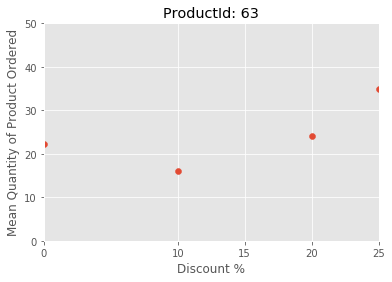

ProductId: 64
Discount Levels: [0.0, 3.0, 5.0, 10.0, 20.0, 25.0]
Mean Quantity: [25.0, 2.0, 15.0, 26.6, 30.0, 30.0]


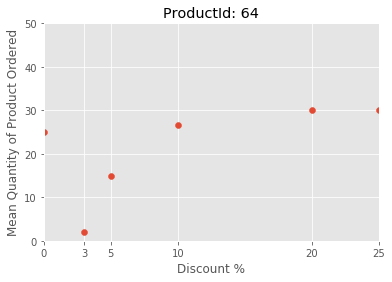

ProductId: 65
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0]
Mean Quantity: [20.69, 24.67, 34.83, 15.0, 12.0]


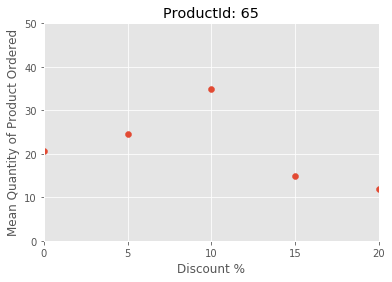

ProductId: 66
Discount Levels: [0.0, 10.0, 15.0]
Mean Quantity: [28.17, 10.0, 60.0]


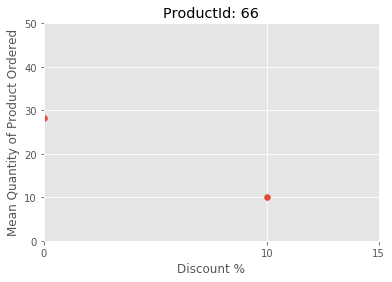

ProductId: 67
Discount Levels: [0.0, 15.0, 20.0, 25.0]
Mean Quantity: [16.43, 40.0, 24.0, 5.0]


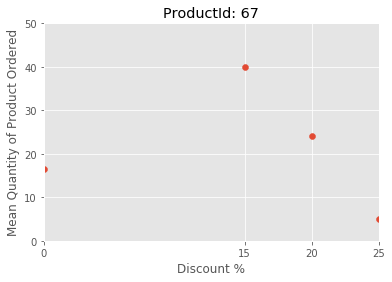

ProductId: 68
Discount Levels: [0.0, 5.0, 10.0, 20.0, 25.0]
Mean Quantity: [23.39, 4.0, 9.0, 20.4, 45.67]


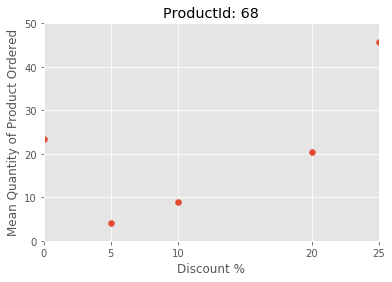

ProductId: 69
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [18.5, 31.67, 21.33, 20.0, 27.25, 36.67]


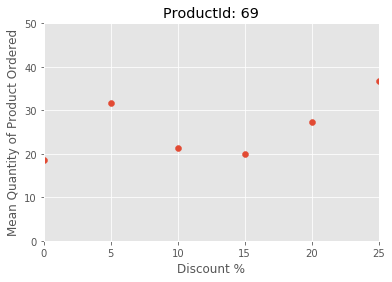

ProductId: 70
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [19.04, 21.0, 26.75, 29.0, 27.33, 17.25]


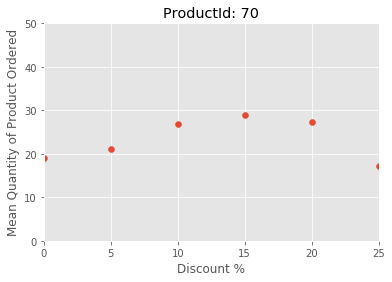

ProductId: 71
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [21.8, 30.0, 24.5, 20.0, 44.75, 32.5]


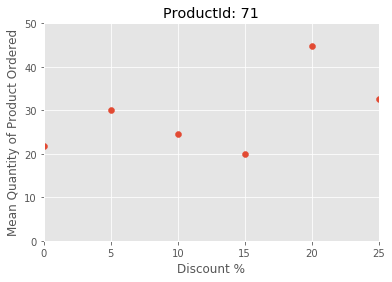

ProductId: 72
Discount Levels: [0.0, 5.0, 10.0, 15.0, 25.0]
Mean Quantity: [19.68, 20.0, 26.33, 27.5, 42.0]


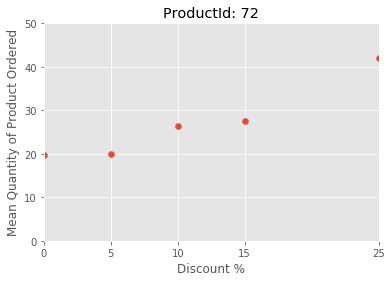

ProductId: 73
Discount Levels: [0.0, 1.0, 5.0, 10.0, 15.0, 20.0]
Mean Quantity: [22.12, 2.0, 24.0, 20.0, 25.0, 20.0]


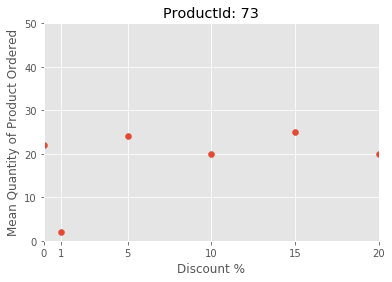

ProductId: 74
Discount Levels: [0.0, 15.0, 25.0]
Mean Quantity: [22.6, 20.0, 25.5]


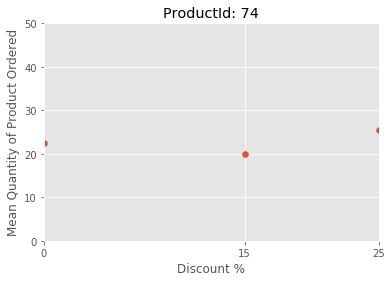

ProductId: 75
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [21.76, 70.0, 20.6, 13.0, 30.17, 4.0]


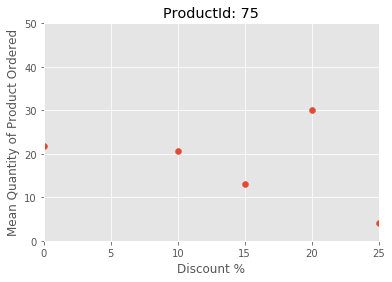

ProductId: 76
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [22.73, 33.0, 30.0, 27.0, 47.0, 20.5]


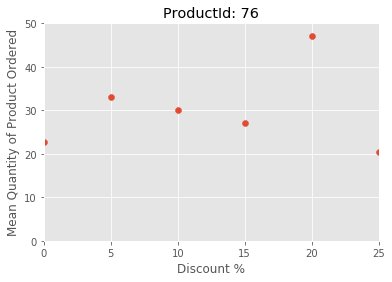

ProductId: 77
Discount Levels: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]
Mean Quantity: [17.87, 38.2, 24.0, 15.0, 2.0, 23.33]


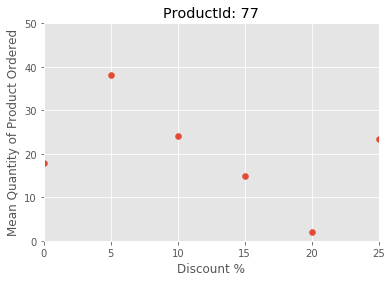

In [134]:
product_ids = mean_quantity_per_discount['ProductId'].unique()
discount_levels = mean_quantity_per_discount['Discount'].unique()


for i, product in enumerate(product_ids):
# for i, product in enumerate([1,2,3]):
    temp = mean_quantity_per_discount[mean_quantity_per_discount.ProductId == product]
    temp = temp.round(2)
    temp.Discount *= 100
        
#     print("temp before sort:")
#     print(temp.head(10))
#     temp.sort_values('Discount', inplace=True)  #sort was not needed
#     print("after sort:")
#     print(temp.head())

    x = list(temp.Discount)
    y = list(temp.Quantity)
    
    print("ProductId:", product)
    print("Discount Levels:", x)
    print("Mean Quantity:", y)

    plt.scatter(x,y)
    plt.xlim(0, .25)
    plt.ylim(0, 50)
    plt.xlabel("Discount %")
    plt.ylabel("Mean Quantity of Product Ordered")
    plt.xticks(x)
    plt.title("ProductId: {}".format(product))

    plt.show()

In [138]:
# make a dataframe as follows:
# each record is a product, each column is a value indicating how much more or less, the mean order quantity is 
# for each discount level, compared to no discount.
np.sort(discount_levels)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1 , 0.15, 0.2 , 0.25])

In [256]:
# no longer needed
# mean_quantity_per_discount['%_change'] = 0
# mean_quantity_per_discount.head(10)

In [250]:
prior_index = 0
pct_change_column = []
for i, row in mean_quantity_per_discount.iterrows():
    print("working on product: ", row['ProductId'])
    current_index = i
    print("current index: ", i)
    if i == 0:   #first row of dataframe
        denominator = row['Quantity']
        pct_change_column.append(0)
        print("no prior index, denominator set to: ", denominator)

    else:
        prior_index = i-1
        #check to make sure this line is the same product
        if mean_quantity_per_discount.iloc[current_index]['ProductId'] == 
        mean_quantity_per_discount.iloc[prior_index]['ProductId']:
            pct_change_column.append(row['Quantity'] / denominator)
            # this was not changing the value in the dataframe because I'm working on a copy of it
#             mean_quantity_per_discount.iloc[current_index]['%_change'] = row['Quantity'] / denominator
            print("prior index, %_change set to: ", row['Quantity'] / denominator)
        else:
            #when this line is a new product, set a new denominator, make %_change value zero
            denominator = row['Quantity']
            pct_change_column.append(0)
            print('new product, denominator set to: ', denominator)
            

working on product:  1.0
current index:  0
no prior index, denominator set to:  17.772727272727273
working on product:  1.0
current index:  1
prior index, %_change set to:  1.1253196930946292
working on product:  1.0
current index:  2
prior index, %_change set to:  0.5626598465473146
working on product:  1.0
current index:  3
prior index, %_change set to:  1.1028132992327366
working on product:  1.0
current index:  4
prior index, %_change set to:  2.391304347826087
working on product:  1.0
current index:  5
prior index, %_change set to:  1.5641943734015344
working on product:  2.0
current index:  6
new product, denominator set to:  21.473684210526315
working on product:  2.0
current index:  7
prior index, %_change set to:  0.7761437908496733
working on product:  2.0
current index:  8
prior index, %_change set to:  0.9313725490196079
working on product:  2.0
current index:  9
prior index, %_change set to:  1.1642156862745099
working on product:  2.0
current index:  10
prior index, %_cha

working on product:  49.0
current index:  252
new product, denominator set to:  25.2
working on product:  49.0
current index:  253
prior index, %_change set to:  1.0912698412698414
working on product:  49.0
current index:  254
prior index, %_change set to:  1.6666666666666667
working on product:  49.0
current index:  255
prior index, %_change set to:  0.5952380952380952
working on product:  50.0
current index:  256
new product, denominator set to:  25.0
working on product:  50.0
current index:  257
prior index, %_change set to:  1.0
working on product:  50.0
current index:  258
prior index, %_change set to:  0.7
working on product:  51.0
current index:  259
new product, denominator set to:  17.68
working on product:  51.0
current index:  260
prior index, %_change set to:  2.615950226244344
working on product:  51.0
current index:  261
prior index, %_change set to:  0.3393665158371041
working on product:  51.0
current index:  262
prior index, %_change set to:  1.9042232277526394
working

In [252]:
len(pct_change_column)

407

In [253]:
len(mean_quantity_per_discount)

407

In [254]:
mean_quantity_per_discount['%_change'] = pct_change_column
# df['a'] = df['a'].map(lambda a: a / 2.)

In [255]:
mean_quantity_per_discount.head(20)

,ProductId,Discount,Quantity,%_change
0,1,0.00,17.772727,0.000000
1,1,0.05,20.000000,1.125320
2,1,0.10,10.000000,0.562660
3,1,0.15,19.600000,1.102813
4,1,0.20,42.500000,2.391304
5,1,0.25,27.800000,1.564194
6,2,0.00,21.473684,0.000000
7,2,0.05,16.666667,0.776144
8,2,0.10,20.000000,0.931373
9,2,0.15,25.000000,1.164216


Now I need to look at the summary stats for each level of discount on each product. For example, when a product is discounted by 25%, what is the distribution of the change in mean quantity of product units oredred.

Steps:
* look at how many instances there are at each level of discount to determine how to segment the data
* make a series for each level of discount, the values being the ratio of change as compared to no discount

In [260]:
# pd.value_counts(horsekick['guardCorps'].values, sort=False)

pd.value_counts(mean_quantity_per_discount['Discount'].values, sort=True)

0.00    77
0.10    68
0.20    64
0.05    64
0.25    64
0.15    62
0.03     3
0.02     2
0.01     1
0.04     1
0.06     1
dtype: int64

I'm going to use the following levels of discount:
* 5%
* 10%
* 15%
* 20%
* 25%


In [259]:
five_percent = mean_quantity_per_discount[mean_quantity_per_discount['Discount'] == .05]['%_change']
five_percent.describe()

count    64.000000
mean      1.289267
std       0.738116
min       0.171004
25%       0.842201
50%       1.097005
75%       1.594358
max       4.371852
Name: %_change, dtype: float64

{'boxes': [<matplotlib.lines.Line2D at 0x1a1aeee0f0>],
 'caps': [<matplotlib.lines.Line2D at 0x1a1aeeeeb8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a1c6198d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a1c619c18>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a1b51a5c0>,
  <matplotlib.lines.Line2D at 0x1a1aeeebe0>]}

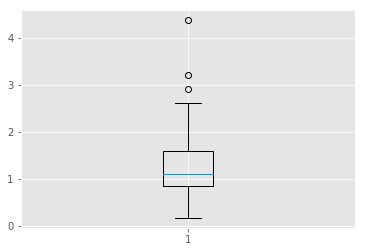

In [261]:
# look at a boxplot
plt.boxplot(five_percent)

In [307]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [379]:
# look at top products by $ sales volume
# grouped = df.groupby('Team')
# print grouped['Points'].agg([np.sum, np.mean, np.std])

grouped = order_detail.groupby('ProductId')
product_volume = pd.DataFrame(grouped['line_total'].agg([np.sum, np.mean, np.std]))
product_volume.sort_values(['sum'], inplace=True, ascending=False)
product_volume.head()

,sum,mean,std
ProductId,,,
38,141396.735,5891.530625,4189.827703
29,80368.672,2511.521000,2005.934622
59,71155.700,1317.698148,1081.612680
62,47234.970,984.061875,783.531816
60,46825.480,918.146667,696.267707


In [352]:
total_sales = product_volume['sum'].sum()
total_sales

1265793.0395

In [390]:
# total sales volume for the top selling ($ value) 36 products
product_volume.head(36)['sum'].sum()

1015339.7270000001

In [392]:
top_36_sales = product_volume.head(36)['sum'].sum()
top_36_sales

1015339.7270000001

In [393]:
# kept increasing # of products, in descending order of total sales, until I got to 80% of total sales
top_36_sales / total_sales

0.802137233588414

In [394]:
product_volume.iloc[35]

sum     12772.000000
mean      982.461538
std       603.323105
Name: 8, dtype: float64

In [395]:
# look at the highest dollar volume products that make up 80% of all sales - 36 products
product_volume[product_volume['sum'] >= 12772]

,sum,mean,std
ProductId,,,
38,141396.7350,5891.530625,4189.827703
29,80368.6720,2511.521000,2005.934622
59,71155.7000,1317.698148,1081.612680
62,47234.9700,984.061875,783.531816
60,46825.4800,918.146667,696.267707
56,42593.0600,851.861200,593.068031
51,41819.6500,1072.298718,1028.185335
17,32698.3800,883.740000,751.333485
18,29171.8750,1080.439815,667.274383


In [401]:
grouped = order_detail.groupby('ProductId')
grouped.describe()

Discount                                                    OrderId  \
             count      mean       std  min  25%    50%     75%   max   count   
ProductId                                                                       
1             38.0  0.077632  0.099795  0.0  0.0  0.000  0.1500  0.25    38.0   
2             44.0  0.102273  0.101703  0.0  0.0  0.075  0.2000  0.25    44.0   
3             12.0  0.016667  0.038925  0.0  0.0  0.000  0.0000  0.10    12.0   
4             20.0  0.075000  0.091047  0.0  0.0  0.025  0.1125  0.25    20.0   
5             10.0  0.075000  0.103414  0.0  0.0  0.000  0.1750  0.25    10.0   
6             12.0  0.030833  0.071663  0.0  0.0  0.000  0.0275  0.25    12.0   
7             29.0  0.027586  0.054423  0.0  0.0  0.000  0.0500  0.20    29.0   
8             13.0  0.065385  0.092161  0.0  0.0  0.000  0.1500  0.25    13.0   
9              5.0  0.100000  0.106066  0.0  0.0  0.100  0.1500  0.25     5.0   
10            33.0  0.043939  0.073694  0.0  0.0  0.000  0.0500  0.25    33.0   
11            38.0  0.056579  0.090920  0.0  0.0  0.000  0.1000  0.25    38.0   
12            14.0  0.064286  0.086444  0.0  0.0  0.025  0.1250  0.25    14.0   
13            40.0  0.042500  0.069384  0.0  0.0  0.000  0.1000  0.25    40.0   
14            22.0  0.067273  0.090983  0.0  0.0  0.000  0.1375  0.25    22.0   
15             6.0  0.016667  0.025820  0.0  0.0  0.000  0.0375  0.05     6.0   
16            43.0  0.066977  0.080254  0.0  0.0  0.050  0.1500  0.25    43.0   
17            37.0  0.062162  0.091595  0.0  0.0  0.000  0.1000  0.25    37.0   
18            27.0  0.079630  0.096336  0.0  0.0  0.000  0.1750  0.25    27.0   
19            37.0  0.055405  0.084807  0.0  0.0  0.000  0.1000  0.25    37.0   
20            16.0  0.046250  0.076322  0.0  0.0  0.000  0.0500  0.25    16.0   
21            39.0  0.056410  0.077102  0.0  0.0  0.000  0.1000  0.25    39.0   
22            14.0  0.021429  0.067123  0.0  0.0  0.000  0.0000  0.25    14.0   
23            20.0  0.037500  0.075872  0.0  0.0  0.000  0.0125  0.25    20.0   
24            51.0  0.056863  0.088893  0.0  0.0  0.000  0.1000  0.25    51.0   
25            18.0  0.086111  0.101178  0.0  0.0  0.050  0.1875  0.25    18.0   
26            32.0  0.051562  0.081799  0.0  0.0  0.000  0.1125  0.25    32.0   
27             9.0  0.027778  0.083333  0.0  0.0  0.000  0.0000  0.25     9.0   
28            33.0  0.037879  0.067350  0.0  0.0  0.000  0.0500  0.25    33.0   
29            32.0  0.064062  0.097744  0.0  0.0  0.000  0.1000  0.25    32.0   
30            32.0  0.081250  0.108323  0.0  0.0  0.000  0.2000  0.25    32.0   
...            ...       ...       ...  ...  ...    ...     ...   ...     ...   
48             6.0  0.108333  0.058452  0.0  0.1  0.125  0.1500  0.15     6.0   
49            21.0  0.030952  0.055848  0.0  0.0  0.000  0.0500  0.15    21.0   
50            10.0  0.025000  0.042492  0.0  0.0  0.000  0.0375  0.10    10.0   
51            39.0  0.051282  0.083104  0.0  0.0  0.000  0.0750  0.25    39.0   
52            29.0  0.041379  0.074485  0.0  0.0  0.000  0.0500  0.25    29.0   
53            30.0  0.038333  0.062537  0.0  0.0  0.000  0.0875  0.20    30.0   
54            36.0  0.072222  0.095950  0.0  0.0  0.000  0.1500  0.25    36.0   
55            33.0  0.077273  0.086685  0.0  0.0  0.050  0.1500  0.25    33.0   
56            50.0  0.062000  0.089534  0.0  0.0  0.000  0.1500  0.25    50.0   
57            23.0  0.028261  0.067126  0.0  0.0  0.000  0.0000  0.25    23.0   
58            18.0  0.100000  0.097014  0.0  0.0  0.100  0.2000  0.25    18.0   
59            54.0  0.047222  0.074869  0.0  0.0  0.000  0.0500  0.25    54.0   
60            51.0  0.063922  0.087774  0.0  0.0  0.000  0.1250  0.25    51.0   
61            24.0  0.070833  0.090790  0.0  0.0  0.000  0.1500  0.25    24.0   
62            48.0  0.054167  0.086192  0.0  0.0  0.000  0.1000  0.25    48.0   
63            17.0  0.041176  0.081462  0

In [397]:




top_36_products = pd.DataFrame(grouped[:35])

product_volume = pd.DataFrame(grouped['line_total'].agg([np.sum, np.mean, np.std]))


top_36_products

TypeError: unhashable type: 'slice'

(array([51., 18.,  3.,  2.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([  1368.7125 ,  15371.51475,  29374.317  ,  43377.11925,
         57379.9215 ,  71382.72375,  85385.526  ,  99388.32825,
        113391.1305 , 127393.93275, 141396.735  ]),
 <a list of 10 Patch objects>)

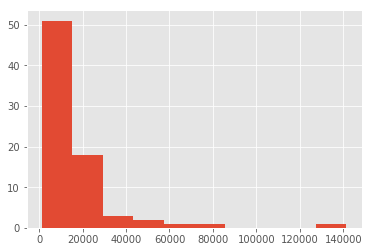

In [339]:
plt.hist(product_volume['sum'])

In [ ]:
five_percent = mean_quantity_per_discount[mean_quantity_per_discount['Discount'] == .05]['%_change']
five_percent.describe()
product_dollar_sales = order_detail[order_detail]

/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Text(0.5, 1.0, 'Change in mean units of a product ordered by the level of discount')

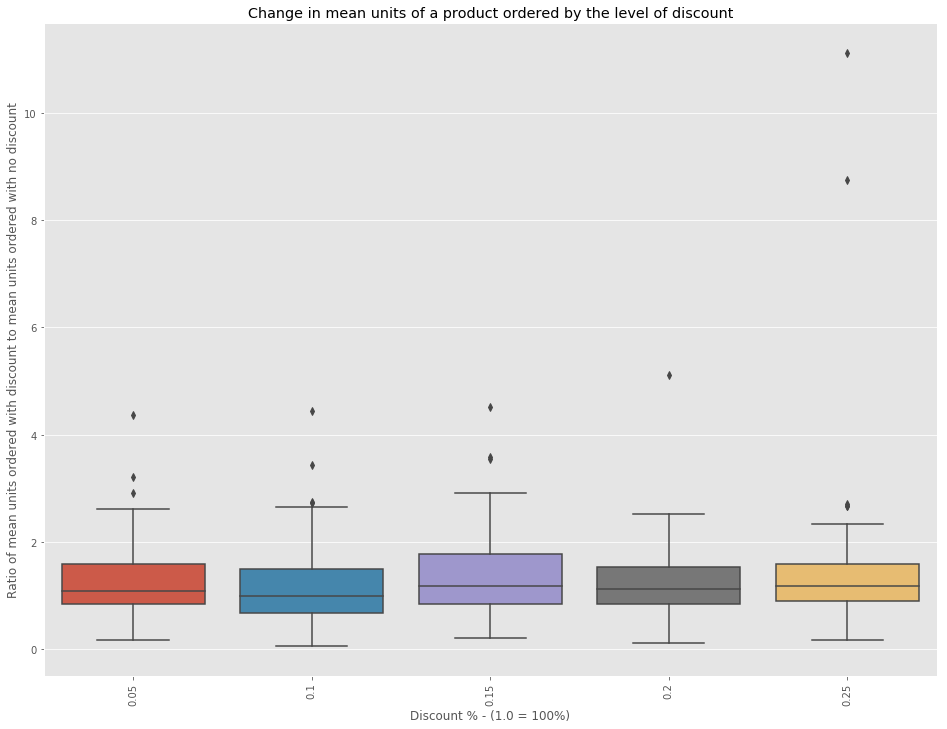

In [292]:
var = 'Discount'
data = pd.concat([mean_quantity_per_discount['%_change'], 
                  mean_quantity_per_discount[mean_quantity_per_discount[var].isin(['.05','.10','.15','.2','.25'])]
                                             [var]], axis=1)
# data = pd.concat([mean_quantity_per_discount['%_change'], mean_quantity_per_discount[var]], axis=1)
f, ax = plt.subplots(figsize=(16,12))
fig = sns.boxplot(x=var, y='%_change', data=data)
# fig.axis(ymin=-.25, ymax=5.0)
plt.xticks(rotation=90)
plt.xlabel('Discount % - (1.0 = 100%)')
plt.ylabel('Ratio of mean units ordered with discount to mean units ordered with no discount')
plt.title('Change in mean units of a product ordered by the level of discount')

In [303]:
#perhaps display the same information with a scatter plot where color is the level of discount

# var = 'Discount'
# data = pd.concat([mean_quantity_per_discount['%_change'], 
#                   mean_quantity_per_discount[mean_quantity_per_discount[var].isin(['.05','.10','.15','.2','.25'])]
#                                              [var]], axis=1)
# # f, ax = plt.subplots(figsize=(16,12))
# sns.lmplot(x=var, y='%_change', data=data, hue='Discount')

# # fig.axis(ymin=-.25, ymax=5.0)
# # plt.xticks(rotation=90)
# plt.xlabel('Discount % - (1.0 = 100%)')
# plt.ylabel('Ratio of mean units ordered with discount to mean units ordered with no discount')
# plt.title('Change in mean units of a product ordered by the level of discount')



In [281]:
# need to do a hypothesis test on this info
# control = no discount
# treatment = discount, could do at various discount levels
# Ho would be that discounts do not increase # of products ordered - treatment mean is equal to control mean
# Ha would be that discounts increase the # of products ordered - treatment is greater than control mean

,%_change,Discount
0,0.000000,NaN
1,1.125320,0.05
2,0.562660,0.10
3,1.102813,0.15
4,2.391304,0.20
5,1.564194,0.25
6,0.000000,NaN
7,0.776144,0.05
8,0.931373,0.10
9,1.164216,0.15


In [305]:
order_detail.head(20)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.00,168.00
1,10248/42,10248,42,9.8,10,0.00,98.00
2,10248/72,10248,72,34.8,5,0.00,174.00
3,10249/14,10249,14,18.6,9,0.00,167.40
4,10249/51,10249,51,42.4,40,0.00,1696.00
5,10250/41,10250,41,7.7,10,0.00,77.00
6,10250/51,10250,51,42.4,35,0.15,1261.40
7,10250/65,10250,65,16.8,15,0.15,214.20
8,10251/22,10251,22,16.8,6,0.05,95.76
9,10251/57,10251,57,15.6,15,0.05,222.30


In [69]:
# do a t-test for the #1 product, #38
# create the list of sample means from both groups of product quantity
# orders with product 



In [403]:
prod_38_discounted = order_detail[(order_detail['ProductId'] == 38) & (order_detail['Discount'] > 0)]
# df[(df>=0)&(df<=20)].dropna()

np.mean(prod_38_discounted['Quantity'])

30.3

In [404]:
prod_38_no_discount = order_detail[(order_detail['ProductId'] == 38) & (order_detail['Discount'] == 0)]
# df[(df>=0)&(df<=20)].dropna()

np.mean(prod_38_no_discount['Quantity'])

22.857142857142858

/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


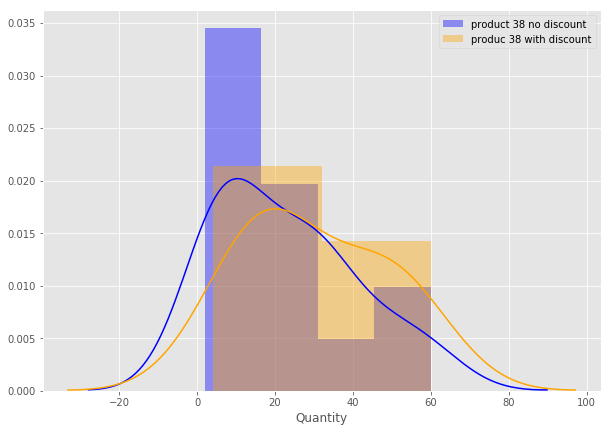

In [389]:
plt.figure(figsize=(10,7))

sns.distplot(prod_38_no_discount['Quantity'], color="blue", label="product 38 no discount")
sns.distplot(prod_38_discounted['Quantity'], color="orange", label='product 38 with discount')
plt.legend()

In [383]:
# not enough records for this sampling idea
discount_sample_means = create_distribution_of_sample_means(
    order_detail[(order_detail['ProductId'] == 38 & order_detail['Discount'] == .05) ]['Quantity'], 10, 30)
# no_discount_sample_means = create_distribution_of_sample_means(no_discount['order_total'], 100, 30)


TypeError: cannot compare a dtyped [float64] array with a scalar of type [bool]

In [ ]:
discount_sample_means

In [ ]:
stats.ttest_ind(no_discount_sample_means, discount_sample_means, equal_var=False)


In [ ]:
# look at the mean quantity ordered for all products at each level of discount
group_data_1 = pd.DataFrame(order_detail.groupby(['Discount'])['Quantity'].mean())
group_data_1.reset_index(inplace=True)
group_data_1

In [ ]:
sns.swarmplot(x='Discount', y='Quantity', data=group_data_1)

In [ ]:
#Look at the total units of products ordered by level of discount
group_data_2 = pd.DataFrame(order_detail.groupby(['Discount'])['Quantity'].sum())
group_data_2.reset_index(inplace=True)
group_data_2


In [ ]:
# get the sum of product units ordered where the prouduct was discounted
group_data_2[(group_data_2['Discount'] > 0)]['Quantity'].sum()

This information is not particularly useful because the total quantity of product units ordered with a discount (22,718) is less than the total number or product units ordered without a discount (28,599).


In [ ]:
# for EDA, look at the total number of orders where there was a discount vs. no discount
order_detail.groupby('OrderId')['OrderId'].nunique().sum()
# df = df.groupby('domain')['ID'].nunique()

In [ ]:
# there are 830 different OrderId's in the order_detail dataframe. I previously determined that there are 
# 2,155 records in the order_detail dataframe and 830 records in the orders dataframe.

In [ ]:
group_data_3 = pd.DataFrame(order_detail.groupby(['Discount'])['OrderId'].nunique())
group_data_3.reset_index(inplace=True)
group_data_3

In [ ]:
group_data_3[(group_data_3['Discount'] > 0)]['OrderId'].sum()  
#this includes some duplicates, because an order could have items with varying levels of discount.
# not sure how to correct this at the moment. One way would be to create a dataframe of orders,
# where each order had a dictionary with discount as the key, and the number of products as the value.


There are 613 orders (with no discount and 387 orders with a discount. 

In [ ]:
sns.boxplot(x='Discount', y='Quantity', data=group_data_2)

In [ ]:
plt.figure(figsize=(10,7))

sns.distplot(no_discount_sample_means, color="blue", label="orders with no discount")
sns.distplot(discount_sample_means, color="orange", label='orders with > 0 discounted items')
plt.legend()

In [ ]:
# this looks at the mean quantity ordered of each product, for each level of discount

group_data = order_detail.groupby(['ProductId', 'Discount'])['Quantity'].mean()
print(group_data)

In [ ]:
# # from dsc-0-09-20-1-sample-z-test-online-ds-pt-100118
# x_bar = x.mean() # sample mean
# n = len(x)       # numnber of samples
# mu = 500         # population mean
# sigma = 100      # population standard deviation

# z = (x_bar - mu)/(sigma/sqrt(n))
# z




# from https://towardsdatascience.com/hypothesis-testing-how-to-determine-significance-ce3991c5db53
# create function to sample with replacement
# def get_sample(df, n):
#     sample = []
#     while len(sample) != n:
#         x = np.random.choice(df)
#         sample.append(x)
#     return sample
# # create function to calculate mean of the sample
# def get_sample_mean(sample):
#     return sum(sample)/len(sample)
# # combine functions to create a sample distribution
# # create a distribution size of 1000 and sample size of 500
# def create_sample_distribution(df, dist_size=1000, n=500):
#     sample_dist = [] 
#     while len(sample_dist) != dist_size:
#         sample = get_sample(df, n)
#         sample_mean = get_sample_mean(sample)
#         sample_dist.append(sample_mean)
        
#     return sample_dist
# # create sample distributions of sample mean for control and target
# ctrl_sample = create_sample_distribution(control)
# exp_sample = create_sample_distribution(exp)